<a href="https://colab.research.google.com/github/azhgh22/ML04_Facial_Expression_Recognition_Challenge/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip
! rm challenges-in-representation-learning-facial-expression-recognition-challenge.zip
! rm fer2013.tar.gz
! rm icml_face_data.csv
! pip install torchview
! pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 77.3 MB/s eta 0:00:00
Mounted at /content/drive
 84% 241M/285M [00:00<00:00, 792MB/s] 
100% 285M/285M [00:00<00:00, 814MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


**Imports**

In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchview import draw_graph

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device available:  cuda


## **Slit data into Train(70%), Validation(15%), Test(15%)**

In [4]:
data = pd.read_csv("train.csv")

In [ ]:
data.head(10)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,255 254 255 254 254 179 122 107 95 124 149 150...


In [5]:
train, X_test = train_test_split(data, test_size=0.3, random_state=42)

val, test = train_test_split(X_test,test_size=0.5,random_state=42)

# train=data.sample(frac=0.7,random_state=7) # Create training of 70% of the data
# test=data.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

# val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
# test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

In [ ]:
train['emotion'].value_counts()

,count
emotion,
3,5031
6,3513
4,3324
2,2862
0,2839
5,2212
1,315


## **Custom DataSet class and Transformer**

In [ ]:
# train['emotion']
data.shape

(28709, 2)

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(np.array(dataframe['emotion'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        pixels = [int(x) for x in self.dataframe.iloc[idx, 1].split()]
        label = self.labels[idx]

        image = Image.fromarray(np.array(pixels,dtype=np.uint8).reshape(48, 48))

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [7]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)

In [8]:
small_dataset = CustomImageDataset(dataframe=train.sample(n=20,random_state=7),transform=transform)
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

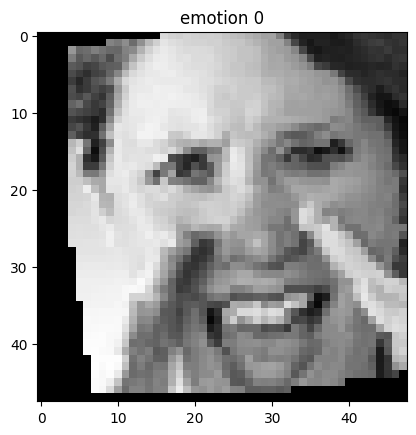

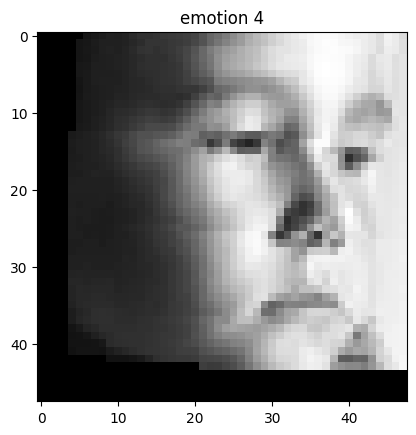

In [9]:
for i in range(2):
  img, label = train_dataset[i]

  plt.imshow(img.squeeze().cpu().numpy(),cmap='gray')
  plt.title(f"emotion {label}")
  plt.show()

## **Hyperparameters**

In [10]:
LR = 1e-3
BATCH_SIZE = 128
EPOCHS = 10
N_CLASSES = 7

# **Dataloaders**

In [11]:
small_loader = DataLoader(small_dataset,batch_size=20,shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## **Model**

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.dropout = nn.Dropout2d(0.1)

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.5):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512, num_classes)

        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))

        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


## **Model Summary**

In [13]:
from torchsummary import summary
summary(ResNet().cuda(), input_size = (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           3,136
       BatchNorm2d-2           [-1, 64, 24, 24]             128
         MaxPool2d-3           [-1, 64, 12, 12]               0
            Conv2d-4           [-1, 64, 12, 12]          36,864
       BatchNorm2d-5           [-1, 64, 12, 12]             128
         Dropout2d-6           [-1, 64, 12, 12]               0
            Conv2d-7           [-1, 64, 12, 12]          36,864
       BatchNorm2d-8           [-1, 64, 12, 12]             128
     ResidualBlock-9           [-1, 64, 12, 12]               0
           Conv2d-10           [-1, 64, 12, 12]          36,864
      BatchNorm2d-11           [-1, 64, 12, 12]             128
        Dropout2d-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 64, 12, 12]          36,864
      BatchNorm2d-14           [-1, 64,

## **Training**

In [14]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [16]:
def train(model, optimizer,scheduler ,train_data_loader,epochs=1,val_data_loader = None,criterion = nn.CrossEntropyLoss()):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    train_epoch_evol_loss = []
    train_epoch_evol_acc = []

    val_epoch_evol_loss = []
    val_epoch_evol_acc = []

    current_loss = 0
    i = 0
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_data_loader):
            model.train()  # put model to training mode
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            loss = criterion(scores, y)
            current_loss = loss.item()
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()


        print('epoch %d, loss = %.4f' % (i, loss.item()))
        print()
        i+=1
        train_accuracy = check_accuracy(train_data_loader, model)
        train_epoch_evol_loss.append(current_loss)
        if val_data_loader is not None:
          val_accuracy = check_accuracy(val_data_loader, model)
          train_epoch_evol_acc.append(train_accuracy)
          val_epoch_evol_acc.append(val_accuracy)
        scheduler.step()
    return val_epoch_evol_acc, train_epoch_evol_acc, train_epoch_evol_loss

In [17]:
model = FacialExpressionResNet().cuda()

LR = 10**-3
EPOCHS=30
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

step_size = 10
gamma = 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

val_epoch_evol_acc, train_epoch_evol_acc, train_epoch_evol_loss = train(model,optimizer,scheduler,train_loader,EPOCHS,val_loader)
# val_epoch_evol_acc, train_epoch_evol_acc, train_epoch_evol_loss = train(model,optimizer,small_loader,10,None)


epoch 0, loss = 1.6756

Got 7058 / 20096 correct (35.12)
Got 1477 / 4306 correct (34.30)
epoch 1, loss = 1.3242

Got 7353 / 20096 correct (36.59)
Got 1580 / 4306 correct (36.69)
epoch 2, loss = 1.4471

Got 8807 / 20096 correct (43.82)
Got 1839 / 4306 correct (42.71)
epoch 3, loss = 1.4917

Got 8685 / 20096 correct (43.22)
Got 1828 / 4306 correct (42.45)
epoch 4, loss = 1.3623

Got 10089 / 20096 correct (50.20)
Got 2085 / 4306 correct (48.42)
epoch 5, loss = 1.3303

Got 10647 / 20096 correct (52.98)
Got 2211 / 4306 correct (51.35)
epoch 6, loss = 1.2742

Got 10165 / 20096 correct (50.58)
Got 2083 / 4306 correct (48.37)
epoch 7, loss = 1.3109

Got 11036 / 20096 correct (54.92)
Got 2307 / 4306 correct (53.58)
epoch 8, loss = 1.1723

Got 11003 / 20096 correct (54.75)
Got 2268 / 4306 correct (52.67)
epoch 9, loss = 1.1035

Got 11236 / 20096 correct (55.91)
Got 2300 / 4306 correct (53.41)
epoch 10, loss = 1.0696

Got 11920 / 20096 correct (59.32)
Got 2434 / 4306 correct (56.53)
epoch 11, los

## **Plot Estimators**

In [18]:
# Assuming you have a model named 'MyPyTorchModel' and input 'x'
x = torch.randn(1, 1, 48, 48) # Example input
model_graph = draw_graph(FacialExpressionResNet(), input_size=x.shape, expand_nested=True)
model_graph.visual_graph.render("model_arch", format="png")

'model_arch.png'

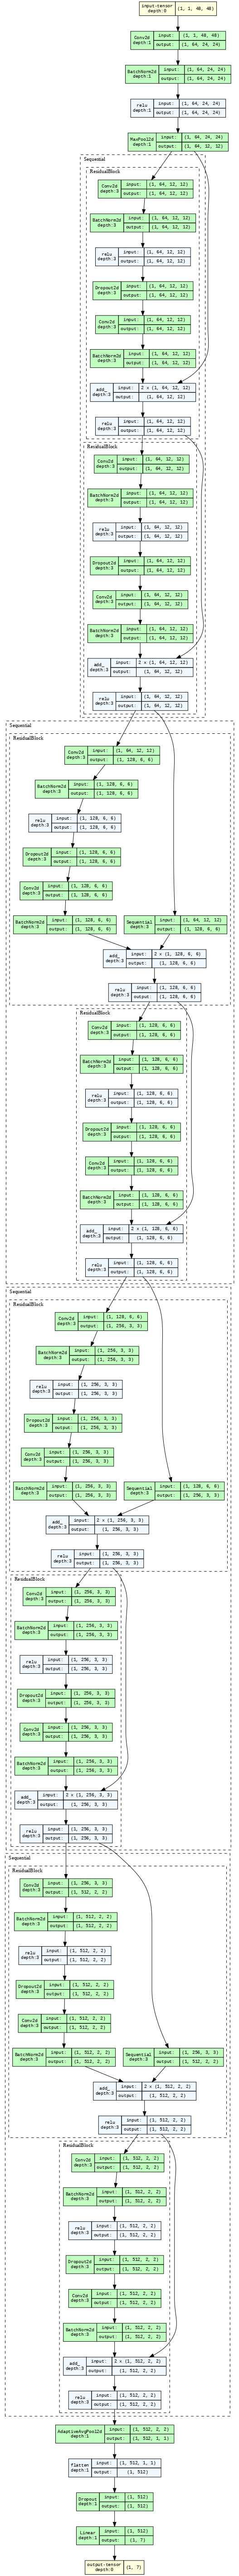

In [19]:
from IPython.display import Image
Image(filename="model_arch.png")

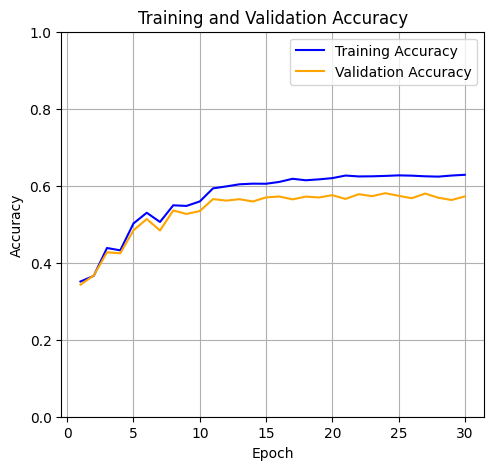

In [20]:
epochs_range = range(1, EPOCHS + 1) # x-axis for epochs, starting from 1
plt.figure(figsize=(12, 5)) # Create a figure with a good size

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(epochs_range, train_epoch_evol_acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_epoch_evol_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 1) # Accuracy typically ranges from 0 to 1

plt.savefig("val_train_accuracy.png")

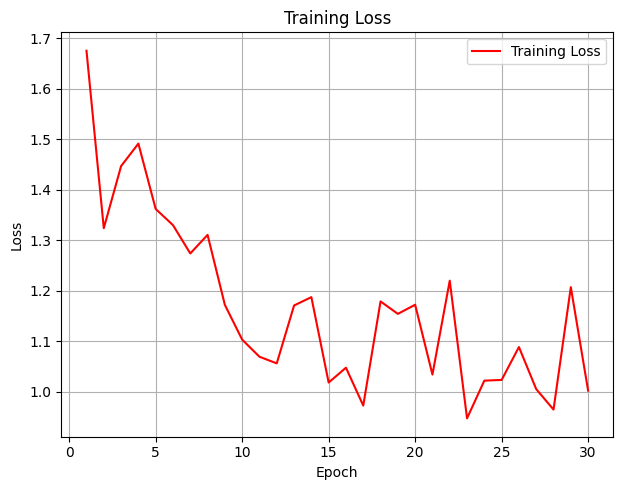

<Figure size 640x480 with 0 Axes>

In [21]:
# plot train loss
plt.figure(figsize=(12, 5)) # Create a figure with a good size

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(epochs_range, train_epoch_evol_loss, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot
plt.savefig("train_loss.png")

## **Testing**

## **Log to Wandb**

In [22]:
! wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: azhgh22 (azhgh22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Currently logged in as: azhgh22 (azhgh22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


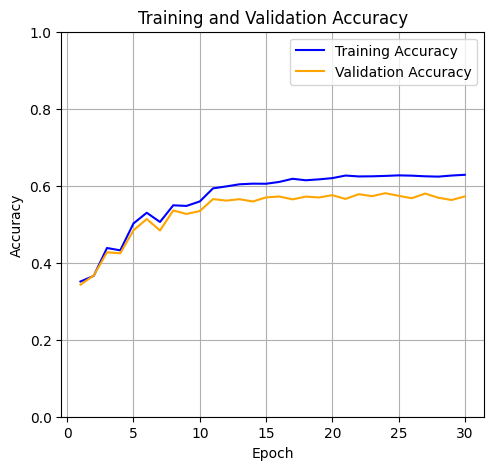

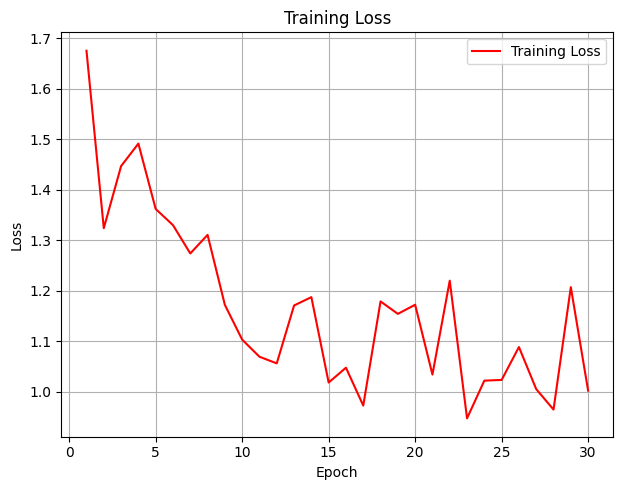

train_acc,▁▁▃▃▅▆▅▆▆▆▇▇▇▇▇███████████████
train_loss,█▅▆▆▅▅▄▄▃▂▂▂▃▃▂▂▁▃▃▃▂▄▁▂▂▂▂▁▃▂
validation_acc,▁▂▃▃▅▆▅▇▆▇█▇█▇██████████████▇█
train_acc,0.62838
train_loss,1.00253
validation_acc,0.57222


<Figure size 640x480 with 0 Axes>

In [23]:
import random
import wandb

# LR = 1e-4
# BATCH_SIZE = 256
# EPOCHS = 10
# N_CLASSES = 7

config = {
    "learning_rate": LR,
    "batch_size" : BATCH_SIZE,
    "epochs" : EPOCHS,
    "architecture": "ResNet",
    "optimizer" : "Adam",
    "loss function" : "Cross-entropy loss",
    "architecture" : "ResNet_run1",
    "activation function" : "Relu",
    "batchnorm" : "Yes",
    "drop out" : 0.1,
    "weight_decay" : 0,
    "maxPullLayer" : "2x2",
    "RandomHorizontalFlip": "Yes",
    "RandomRotation": "YES",
    "RandomAffine": "YES",
    "Learning Rate Scheduler" : {
        "step_size" : 10,
        "gamma" : 0.1
    }
}

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="azhgh22-free-university-of-tbilisi-",
    # Set the wandb project where this run will be logged.
    project="Face recognition",
    # Track hyperparameters and run metadata.
    config=config,
    name=config["architecture"]
)

# model = EmotionNet().cuda()

# optimizer = Adam(model.parameters(), lr=LR,weight_decay=config['weight_decay'])
# criterion = nn.CrossEntropyLoss()
# val_epoch_evol_acc, train_epoch_evol_acc, train_epoch_evol_loss = train(model,optimizer,train_loader,EPOCHS,val_loader,criterion)


for i in range(1,EPOCHS+1):
  run.log({"train_acc": train_epoch_evol_acc[i-1]},step=i)
  run.log({"validation_acc": val_epoch_evol_acc[i-1]},step=i)
  run.log({"train_loss" : train_epoch_evol_loss[i-1]},step=i)

epochs_range = range(1, EPOCHS + 1) # x-axis for epochs, starting from 1
plt.figure(figsize=(12, 5)) # Create a figure with a good size

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(epochs_range, train_epoch_evol_acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_epoch_evol_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 1) # Accuracy typically ranges from 0 to 1

plt.savefig("val_train_accuracy.png")

# plot train loss
plt.figure(figsize=(12, 5)) # Create a figure with a good size

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(epochs_range, train_epoch_evol_loss, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot
plt.savefig("train_loss.png")

run.save("val_train_accuracy.png")


x = torch.randn(1, 1, 48, 48) # Example input
model_graph = draw_graph(ResNet(), input_size=x.shape, expand_nested=True)
model_graph.visual_graph.render("model_arch", format="png")

# run.save("model_arch.png");

run.log({"Training val Curves": wandb.Image("val_train_accuracy.png")})
run.log({"Architecure": wandb.Image("model_arch.png")})

torch.save(model.state_dict(), f'{config["architecture"]}.pt')
run.save(f'{config["architecture"]}.pt')

# Finish the run and upload any remaining data.
run.finish()

## **Ansemble prev models**

In [ ]:
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="azhgh22-free-university-of-tbilisi-",
    # Set the wandb project where this run will be logged.
    project="Face recognition",
    # Track hyperparameters and run metadata.
)


artifact_path = "azhgh22-free-university-of-tbilisi-/Face recognition/my-model:latest"
artifact = run.use_artifact(artifact_path, type="model")

